In [1]:
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import torchvision

In [2]:
seed = 256
torch.manual_seed(seed)
torch.set_default_dtype(torch.double)

1. Load, analyse and preprocess the CIFAR-10 dataset. Split it into 3 datasets: training, validation and test.
Take a subset of these datasets by keeping only 2 labels: bird and plane.

In [3]:
def load_cifar10():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    cifar10_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    cifar10_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    return cifar10_train, cifar10_test

In [4]:
cifar10_train, cifar10_test = load_cifar10()
label_map = {0: 0, 2: 1}

cifar2_train = [(img, label_map[label]) for img, label in cifar10_train if label in [0, 2]]
cifar2_test = [(img, label_map[label]) for img, label in cifar10_test if label in [0, 2]]

Files already downloaded and verified
Files already downloaded and verified


In [5]:
num_train_total = len(cifar2_train)
num_train = int(0.8 * num_train_total)
num_val = num_train_total - num_train

cifar2_train, cifar2_val = random_split(cifar2_train, [num_train, num_val])

In [6]:
print("Train Size:", len(cifar2_train))
print("Validation Size:", len(cifar2_val))
print("Test Size:", len(cifar2_test))

Train Size: 8000
Validation Size: 2000
Test Size: 2000


In [7]:
airplane_count_train = sum(label == 0 for _, label in cifar2_train)
bird_count_train = sum(label == 1 for _, label in cifar2_train)

airplane_count_val = sum(label == 0 for _, label in cifar2_val)
bird_count_val = sum(label == 1 for _, label in cifar2_val)

airplane_count_test = sum(label == 0 for _, label in cifar2_test)
bird_count_test = sum(label == 1 for _, label in cifar2_test)

print(f"Train: {airplane_count_train} Airplanes, {bird_count_train} Birds")
print(f"Validation: {airplane_count_val} Airplanes, {bird_count_val} Birds")
print(f"Test: {airplane_count_test} Airplanes, {bird_count_test} Birds")

Train: 4009 Airplanes, 3991 Birds
Validation: 991 Airplanes, 1009 Birds
Test: 1000 Airplanes, 1000 Birds


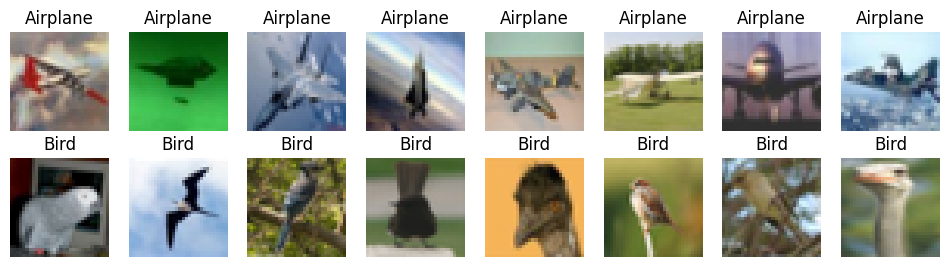

In [8]:
def show_imgs(imgs, titles, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(12, 3))

    for i, (img, title) in enumerate(zip(imgs, titles)):
        img = img / 2 + 0.5
        npimg = img.numpy()
        row = i // cols
        col = i % cols
        axes[row, col].imshow(np.transpose(npimg, (1, 2, 0)))
        axes[row, col].set_title(title)
        axes[row, col].axis('off')

    plt.show()


airplane_indices = [i for i, (img, label) in enumerate(cifar2_train) if label == 0][:8]
bird_indices = [i for i, (img, label) in enumerate(cifar2_train) if label == 1][:8]

airplane_images = [cifar2_train[i][0] for i in airplane_indices]
bird_images = [cifar2_train[i][0] for i in bird_indices]

show_imgs(airplane_images + bird_images, ['Airplane'] * 8 + ['Bird'] * 8, rows=2, cols=8)

In [9]:
def set_device():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training on device {device}.")
    return device

2. Write a `MyMLP` class that implements a MLP in PyTorch (so only fully connected layers) such that:
(a) The input dimension is 3072 (= 32 $\times$ 32 $\times$ 3) and the output dimension is 2 (for the 2 classes).
(b) The hidden layers have respectively 512, 128 and 32 hidden units.
(c) All activation functions are `ReLU`. The last layer has no activation function since the
cross-entropy loss already includes a softmax activation function.

In [10]:
class MyMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 2)

    def forward(self, x):
        x = torch.flatten(x, 1)  # transforming into 1-dim vector 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

3. Write a `train(n_epochs, optimizer, model, loss_fn, train_loader)` function that trains model for `n_epochs`
epochs given an optimizer `optimizer`, a loss function `loss_fn` and a dataloader `train_loader`.

In [11]:
def train(n_epochs, optimizer, model, loss_fn, train_loader):
    print(" --------- Using Pytorch's SGD ---------")

    for epoch in range(1, n_epochs + 1):
        train_loss = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device=device, dtype=torch.double), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        if epoch == 1 or epoch % 5 == 0:
            timestamp = datetime.now().strftime('%H:%M:%S.%f')
            avg_loss = train_loss / len(train_loader)
            print(f"{timestamp}  |  Epoch {epoch}  |  Training loss {round(avg_loss, 5)}")

In [12]:
def train_manual_update(n_epochs, lr, model, loss_fn, train_loader):
    print(" --------- Using manual update ----------")

    for epoch in range(1, n_epochs + 1):
        train_loss = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device=device, dtype=torch.double), labels.to(device)

            # forward + backward
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            loss.backward()

            # manual parameter update using the gradient descent rule
            with torch.no_grad():
                for name, p in model.named_parameters():
                    p.data -= lr * p.grad
                    p.grad.zero_() # zero the gradients after updating

            train_loss += loss.item()

        if epoch == 1 or epoch % 5 == 0:
            timestamp = datetime.now().strftime('%H:%M:%S.%f')
            avg_loss = train_loss / len(train_loader)
            print(f"{timestamp}  |  Epoch {epoch}  |  Training loss {round(avg_loss, 5)}")

In [13]:
def evaluate_accuracy(model, loader):
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device=device, dtype=torch.double), labels.to(device)

            # calculate outputs by running images through the network
            outputs = model(imgs)

            # class with the highest value is what we choose as prediction
            _, predicted = torch.max(outputs, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [14]:
batch_size = 256

train_loader = DataLoader(cifar2_train, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(cifar2_val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(cifar2_test, batch_size=batch_size, shuffle=False)

In [15]:
n_epochs = 30
l_rate = 0.01
momentum = [0, 0, 0.9, 0.9, 0.9, 0.8]
weight_decay = [0, 0.01, 0, 0.01, 0.001, 0.01]

In [16]:
device = set_device()

Training on device cpu.


In [17]:
for mom, decay in zip(momentum, weight_decay):
    print(" =========================================================")
    print(f"   Current parameters:\nlr = {l_rate}\nmom = {mom}\ndecay = {decay}\n")

    torch.manual_seed(seed)
    model1 = MyMLP().to(device)
    optimizer = optim.SGD(model1.parameters(), lr=l_rate, momentum=mom, weight_decay=decay)
    loss_fn = nn.CrossEntropyLoss()

    train(n_epochs, optimizer, model1, loss_fn, train_loader)

    train_accuracy_model1 = evaluate_accuracy(model1, train_loader)
    val_accuracy_model1 = evaluate_accuracy(model1, val_loader)
    print("\n --- Accuracies ---")
    print(f"Training\nAccuracy: {train_accuracy_model1:.2f}")
    print(f"Validation\nAccuracy: {val_accuracy_model1:.2f}\n")

    torch.manual_seed(seed)
    model2 = MyMLP().to(device)

    train_manual_update(n_epochs, l_rate, model2, loss_fn, train_loader)

    train_accuracy_model2 = evaluate_accuracy(model2, train_loader)
    val_accuracy_model2 = evaluate_accuracy(model2, val_loader)
    print("\n --- Accuracies ---")
    print(f"Training\nAccuracy: {train_accuracy_model2:.2f}")
    print(f"Validation\nAccuracy: {val_accuracy_model2:.2f}\n")

   Current parameters:
lr = 0.01
mom = 0
decay = 0

 --------- Using Pytorch's SGD ---------
18:45:29.469545  |  Epoch 1  |  Training loss 0.69209
18:45:30.471038  |  Epoch 5  |  Training loss 0.64788
18:45:31.737919  |  Epoch 10  |  Training loss 0.55918
18:45:33.125602  |  Epoch 15  |  Training loss 0.49471
18:45:34.423438  |  Epoch 20  |  Training loss 0.46545
18:45:35.718060  |  Epoch 25  |  Training loss 0.4443
18:45:37.027877  |  Epoch 30  |  Training loss 0.42322

 --- Accuracies ---
Training
Accuracy: 0.82
Validation
Accuracy: 0.82

 --------- Using manual update ----------
18:45:37.481885  |  Epoch 1  |  Training loss 0.69209
18:45:38.560372  |  Epoch 5  |  Training loss 0.64788
18:45:39.893739  |  Epoch 10  |  Training loss 0.55918
18:45:41.235916  |  Epoch 15  |  Training loss 0.49471
18:45:42.546920  |  Epoch 20  |  Training loss 0.46545
18:45:43.859546  |  Epoch 25  |  Training loss 0.4443
18:45:45.165863  |  Epoch 30  |  Training loss 0.42322

 --- Accuracies ---
Training